In [18]:
!pip install albumentations > /dev/null
!git clone https://github.com/qubvel/efficientnet.git
!pip install console_progressbar

Cloning into 'efficientnet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 310 (delta 1), reused 0 (delta 0), pack-reused 305
Receiving objects: 100% (310/310), 835.11 KiB | 8.03 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [19]:
import os
import scipy.io
import cv2 as cv
import numpy as np
import keras
import random
import pandas as pd
import matplotlib.pyplot as plt

from console_progressbar import ProgressBar
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D,AveragePooling2D

In [20]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/devkit/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
img_width, img_height = 299, 299

def save_train_data(fnames, labels, bboxes):
    src_folder ='/content/drive/MyDrive/devkit/cars_train/'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = '/content/drive/MyDrive/devkit/data/train/'
        else:
            dst_folder = '/content/drive/MyDrive/devkit/data/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [22]:
def save_test_data(fnames, bboxes):
    src_folder = '/content/drive/MyDrive/devkit/cars_test/'
    dst_folder = '/content/drive/MyDrive/devkit/data/test/'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = src_folder + str(fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [23]:
def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('/content/drive/MyDrive/devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)

In [24]:
def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('/content/drive/MyDrive/devkit/cars_test_annos_withlabels.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

In [25]:
cars_meta = scipy.io.loadmat('/content/drive/MyDrive/devkit/cars_meta.mat')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

In [ ]:
process_train_data()
process_test_data()

In [26]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'][1:])
    plt.plot(history.history['val_accuracy'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [27]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

import keras.callbacks as callbacks

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  
        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [28]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './data/train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        './data/valid',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 6614 images belonging to 196 classes.
Found 1793 images belonging to 196 classes.


In [29]:
def build_finetune_model(base_model, dropout, num_classes):

    x = base_model.output
    
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [ ]:
HEIGHT = 299
WIDTH = 299

input_shape=(HEIGHT, WIDTH, 3)

dropout = 0.7
epochs = 30
swa = SWA('./keras_swa.model',epochs-3)

base_model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(HEIGHT, WIDTH, 3))

model = build_finetune_model(base_model, dropout=dropout, num_classes=196)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)

history = model.fit(train_generator,validation_data=validation_generator,steps_per_epoch=205,epochs=epochs,verbose=1,validation_steps=52,callbacks=snapshot.get_callbacks())

model.load_weights('./keras_swa.model')

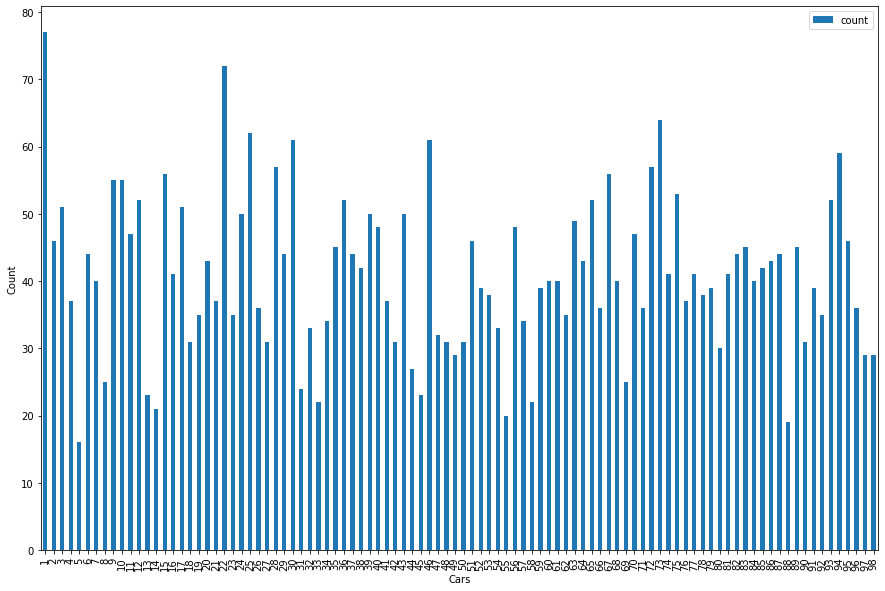

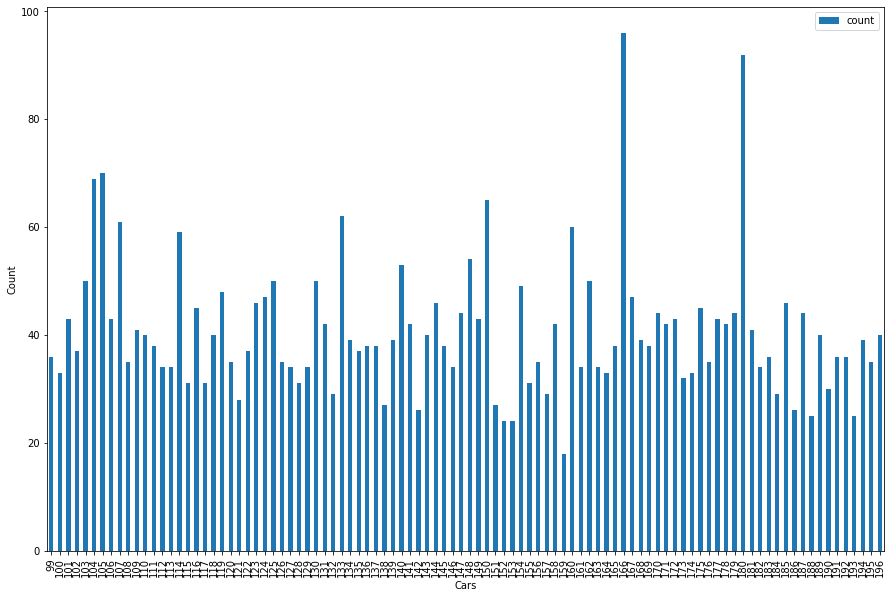

In [71]:
import csv
df=pd.read_csv('/content/drive/MyDrive/devkit/group15.csv')
freq_labels = df.groupby('pred_label').count()
freq_labels = freq_labels.rename(columns={'filename': 'count'})
freq_labels = freq_labels.sort_values(by='pred_label', ascending=True)

df1 = freq_labels[0:98]
df2 = freq_labels[98:196]
df1.head(98).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");
df2.head(98).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");